1. The weights listed below were recorded in the !Kung census, but heights
were not recorded for these individuals. Provide predicted heights and 89%
compatibility intervals for each of these individuals. That is, fill in the table
below, using model-based predictions.

| Individual | weight | expected height | 89% interval |
| --- | --- | --- | --- |
| 1 | 45 | . | . | 
| 2 | 40 | . | . | 
| 3 | 65 | . | . | 
| 4 | 31 | . | . | 
| 5 | 53 | . | . | 


In order to predict this we build up a 3rd order polynomial fit:

$$µ_i = α + β_1x_i + β_2x^2_i + β_3x^3_i$$

The model is then:

$$
\begin{equation*}
h_i ∼ \textrm{Normal}(µ_i, σ) \\
µ_i = α + β_1x_i + β_2x^2 + β_3x^3_i  \\
α ∼ \textrm{Normal}(178, 20) \\
β1 ∼ \textrm{Log-Normal}(0, 1) \\
β2 ∼ \textrm{Normal}(0, 1) \\
β3 ∼ \textrm{Normal}(0, 1) \\
σ ∼ \textrm{Uniform}(0, 50) \\
\end{equation*}
$$

## Load data and build 3rd order fit

In [1]:
# Load the data
library(rethinking) 
data(Howell1) 
d <- Howell1 

# Save as CSV (to use in python notebook)
write.csv(d, file='howell.csv')

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
# Get the zeroed weights for all ages
d$weight_s <- ( d$weight - mean(d$weight) )/sd(d$weight) 
# 2nd order
d$weight_s2 <- d$weight_s^2 
# 3rd order
d$weight_s3 <- d$weight_s^3

In [3]:
# Fit the model
cubic_posterior <- quap( 
    alist(
        height ~ dnorm( mu , sigma ) , 
        mu <- a + b1*weight_s + b2*weight_s2 + b3*weight_s3 , 
        a ~ dnorm( 178 , 20 ) , 
        b1 ~ dlnorm( 0 , 1 ) , 
        b2 ~ dnorm( 0 , 1 ) ,
        b3 ~ dnorm( 0 , 1 ), 
        sigma ~ dunif( 0 , 50 )
) , data=d )

In [4]:
# Summarize our fit
precis(cubic_posterior)

,mean,sd,5.5%,94.5%
a,146.394773,0.3099733,145.899376,146.890171
b1,15.220988,0.4762470,14.459853,15.982123
b2,-6.203146,0.2571458,-6.614115,-5.792178
b3,3.582750,0.2287642,3.217140,3.948359
sigma,4.829681,0.1469267,4.594864,5.064498


In [5]:
# Pre-defined (and hard-coded range) - how to improve?
weight.seq <- seq( from=-2.2 , to=2 , length.out=30 ) 

# Map out the data
pred_dat <- list( weight_s=weight.seq , weight_s2=weight.seq^2, weight_s3=weight.seq^3 ) 

In [6]:
# Generate posterior predictions
posterior_sample <- link( cubic_posterior , data=pred_dat ) 

# Get some stats on the 
mu.mean <- apply( posterior_sample , 2 , mean ) 
mu.PI <- apply( posterior_sample , 2 , PI , prob=0.89 ) 

# Get simulated data
sim.height <- sim( cubic_posterior , data=pred_dat ) 
# Get PI
height.PI <- apply( sim.height , 2 , PI , prob=0.89 )

In [7]:
# We will predict these weights below but want to mark them for now.
weights_to_predict = c(45, 40, 65, 31, 53)

# We will predict these weights below but want to mark them for now.
empty = rep(0, length(weights_to_predict))

dat = data.frame(
    weight=weights_to_predict, 
    weight_s=empty, 
    predicated_height=empty, 
    low=empty, 
    high=empty
)
dat$weight_s = (dat$weight - mean(d$weight) )/sd(d$weight) 

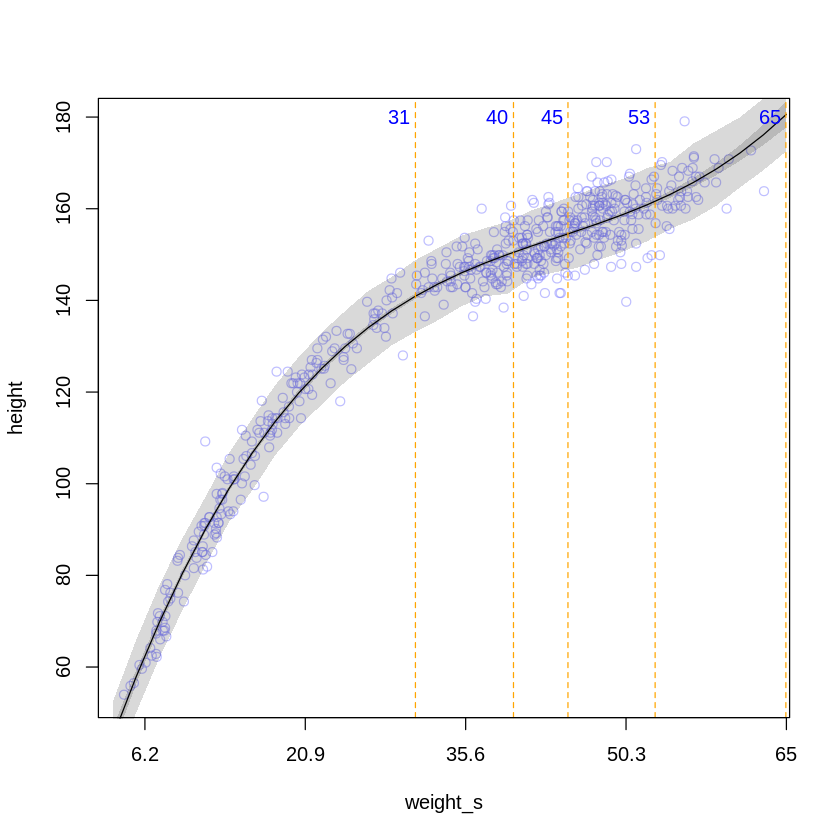

In [8]:
# Plot
plot( height ~ weight_s , d , col=col.alpha(rangi2,0.5), xaxt='n') 
lines( weight.seq , mu.mean ) 
shade( mu.PI , weight.seq ) 
shade( height.PI , weight.seq )

for (i in 1:length(dat)){
    abline(v=dat$weight_s[i], col='orange', lty=2)
    text(x=dat$weight_s[i]-0.1, y=180, labels=concat(dat$weight[i]), col='blue')
}

# Fix axis (surely there is a better way?)
at <- c(-2,-1,0,1,2) 
labels <- at*sd(d$weight) + mean(d$weight) 
axis( side=1 , at=at , labels=round(labels,1) )

## Predictions

In [9]:
predict = function(i, do_plot=FALSE){
    # Pull some sample parameters
    post <- extract.samples( cubic_posterior )

    # Get our desired value as zeroed
    x_i = (i - mean(d$weight) )/sd(d$weight) 

    # Use sample parameters to find predicted height
    mu.pred = post$a + (post$b1 * ( x_i )) + (post$b2 * ( x_i^2 )) + (post$b3 * ( x_i^3 ))
    
    # Use our mu and sigma values to pull from normal distribution
    mus = rnorm(n=nrow(post), mean=mu.pred, sd=post$sigma)
        
    # Get density interval   
    mu.hpdi = HPDI( mus , prob=0.89 )

    # MAP (mean) for predictions
    map = mean(mu.pred)

    if(do_plot){
        dens( mus , 
             col=rangi2 , 
             lwd=2 , 
             xlab=concat("Weight=", round(i), 
                         " Pred Height=",round(map, 2),' ± ', round(mean(post$sigma), 2)) 
            )    
        abline(v=map, col='red', lty=2)
        abline(v=mu.hpdi[1], col='green', lty=2)
        abline(v=mu.hpdi[2], col='green', lty=2)        
    }
    
    return(c(map, mu.hpdi[1],  mu.hpdi[2]))
}

# Predicted heights

These are generated along with the plots below.

In [10]:
# Do the prediction for each desired weight.
# There is surely a better way to do this.
for (i in 1:length(weights_to_predict)){
    preds = predict(weights_to_predict[i])    
    dat[i, 3] = preds[1]
    dat[i, 4] = preds[2]
    dat[i, 5] = preds[3]
}

## The answer

In [11]:
round(dat, 2)

weight,weight_s,predicated_height,low,high
45,0.64,154.51,146.96,162.49
40,0.30,150.47,142.64,158.10
65,2.00,180.56,172.39,188.71
31,-0.31,140.90,133.45,148.79
53,1.18,161.62,153.95,169.24


## Plots

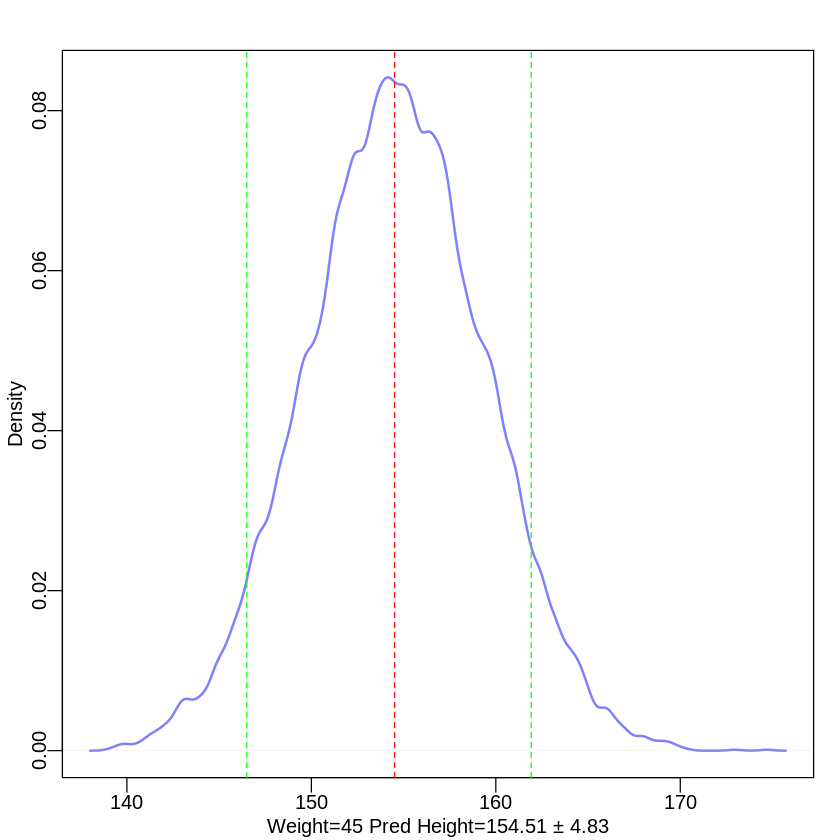

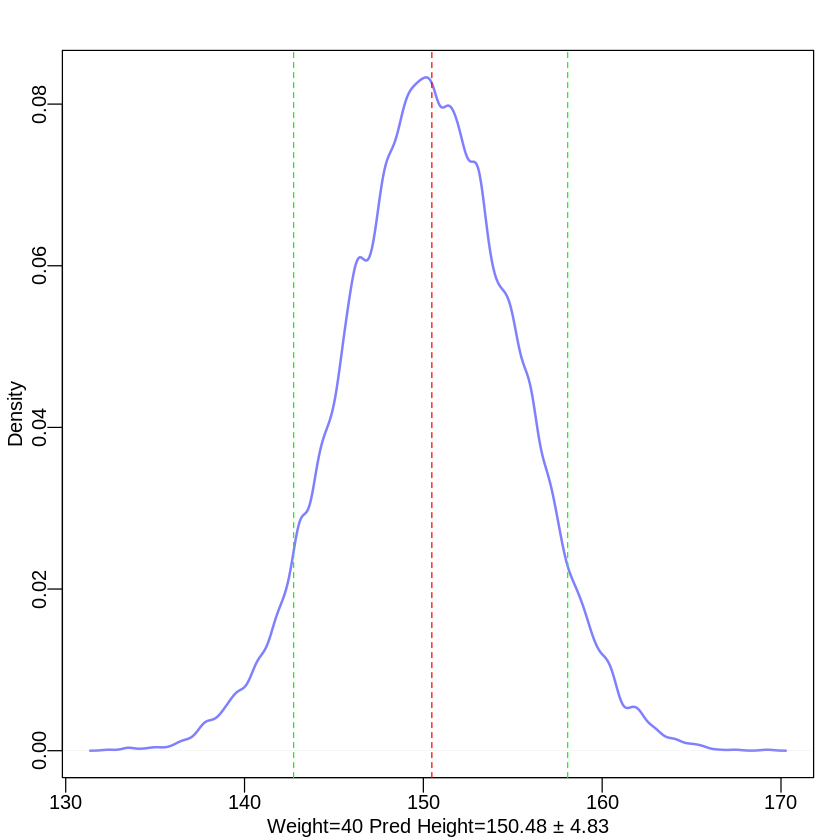

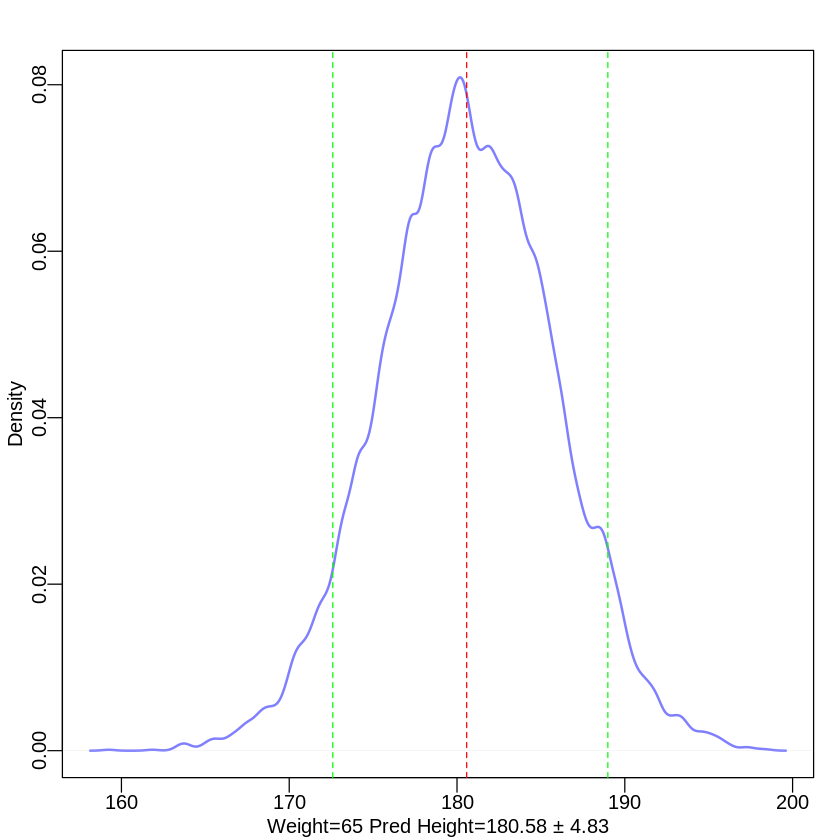

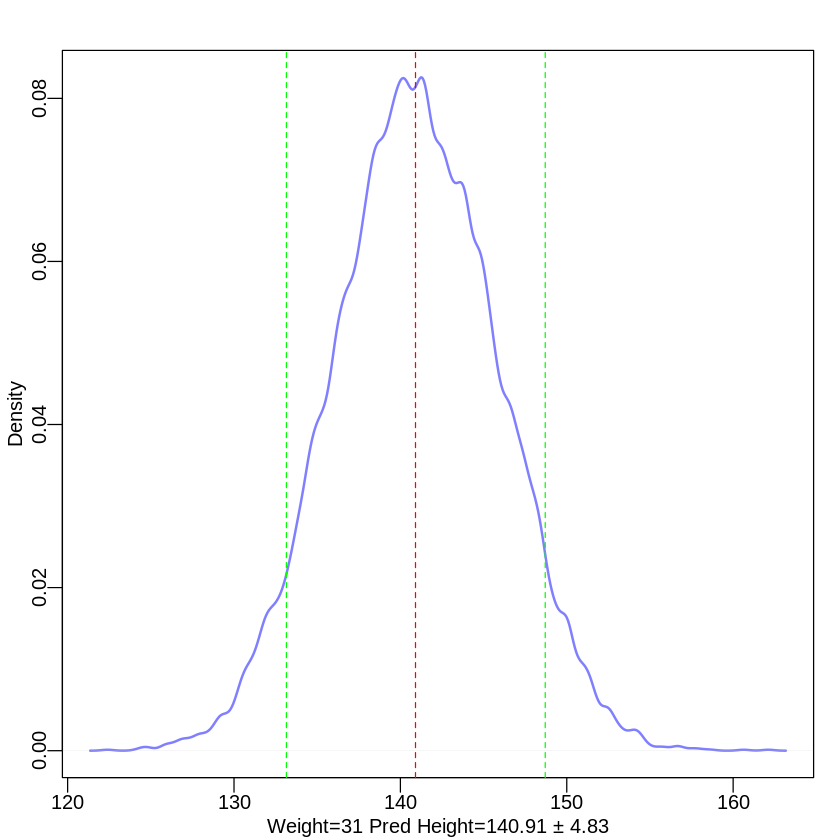

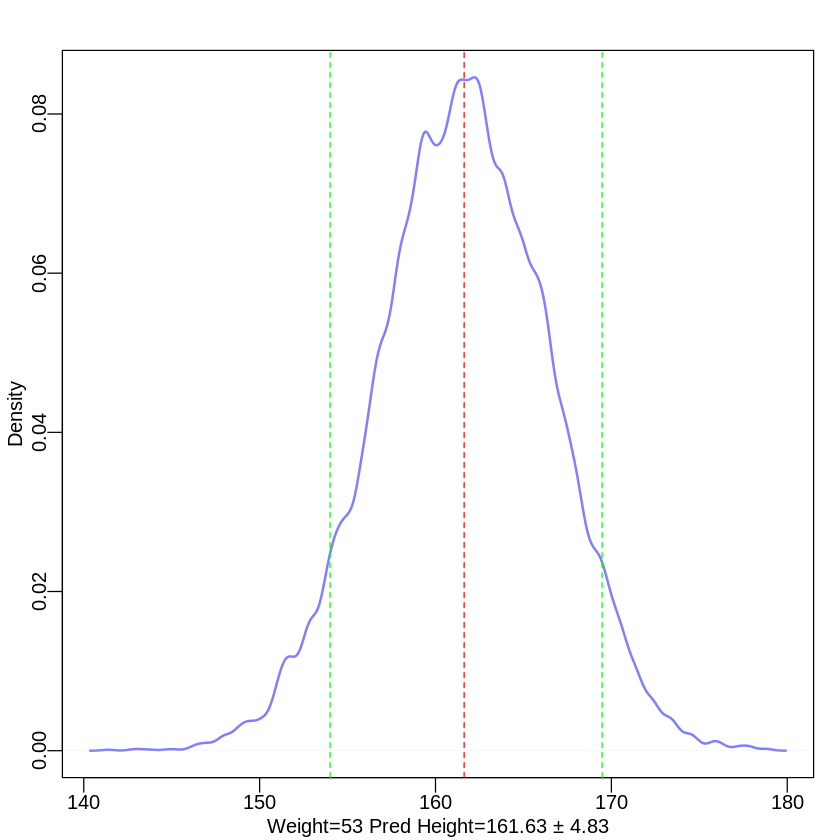

In [12]:
for (i in 1:length(weights_to_predict)){
    preds = predict(weights_to_predict[i], do_plot = TRUE)    
}